In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

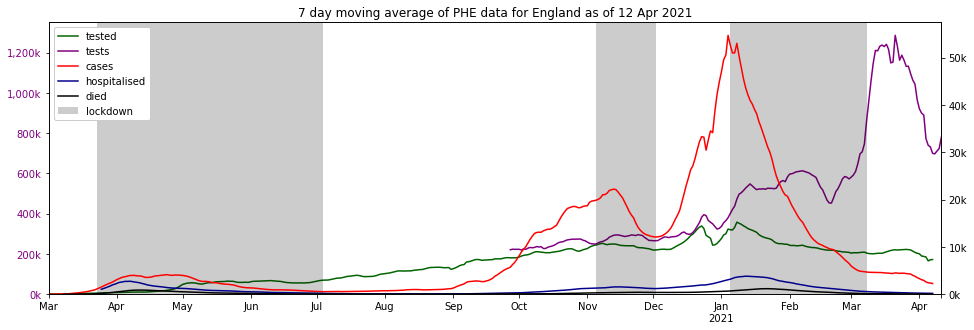

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

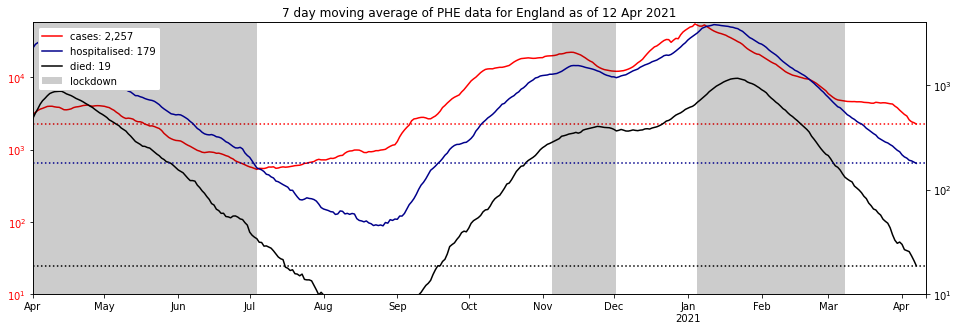

In [3]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

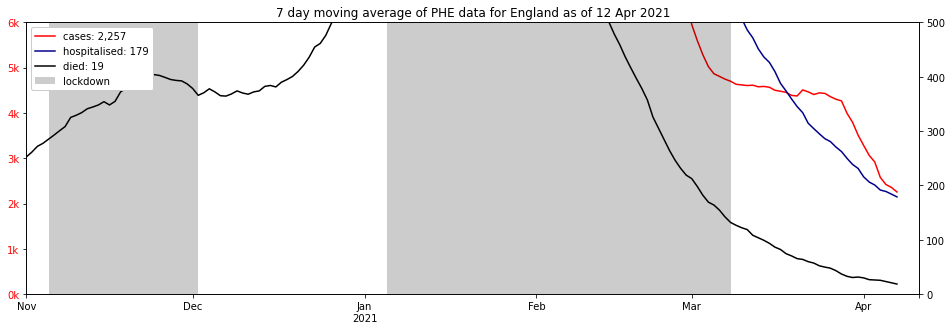

In [4]:
plot_summary(earliest_date='2020-11-01', show_latest=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=6_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=500)

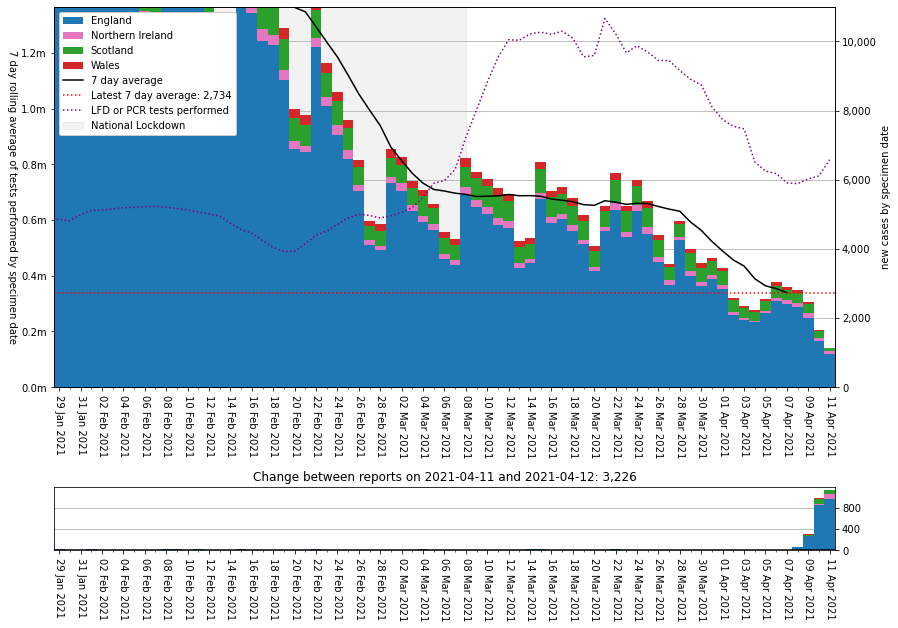

In [5]:
plot_areas(for_date, 'cases_nations', ylim=11_000, earliest='2021-01-29')

In [6]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,11 Apr 21,"+6,338,332","+27,107,590","+6,338,332","+160,454","+36,599","+160,454"
Northern Ireland,11 Apr 21,"+199,500","+826,412","+199,500","+4,890","+6,380","+4,890"
Scotland,11 Apr 21,"+590,174","+2,668,723","+590,174","+21,299","+11,145","+21,299"
Wales,11 Apr 21,"+528,199","+1,587,851","+528,199","+3,022","+15,099","+3,022"


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,6338332.0,27107590.0,20769258.0,56286961,11.260747,36.898880,51.840374
1,Northern Ireland,N92000002,199500.0,826412.0,626912.0,1893667,10.535115,33.105715,56.359170
2,Scotland,S92000003,590174.0,2668723.0,2078549.0,5463300,10.802519,38.045668,51.151813
3,Wales,W92000004,528199.0,1587851.0,1059652.0,3152879,16.752911,33.609028,49.638061


'partial: 32,190,576 (48.2%), full: 7,656,205'

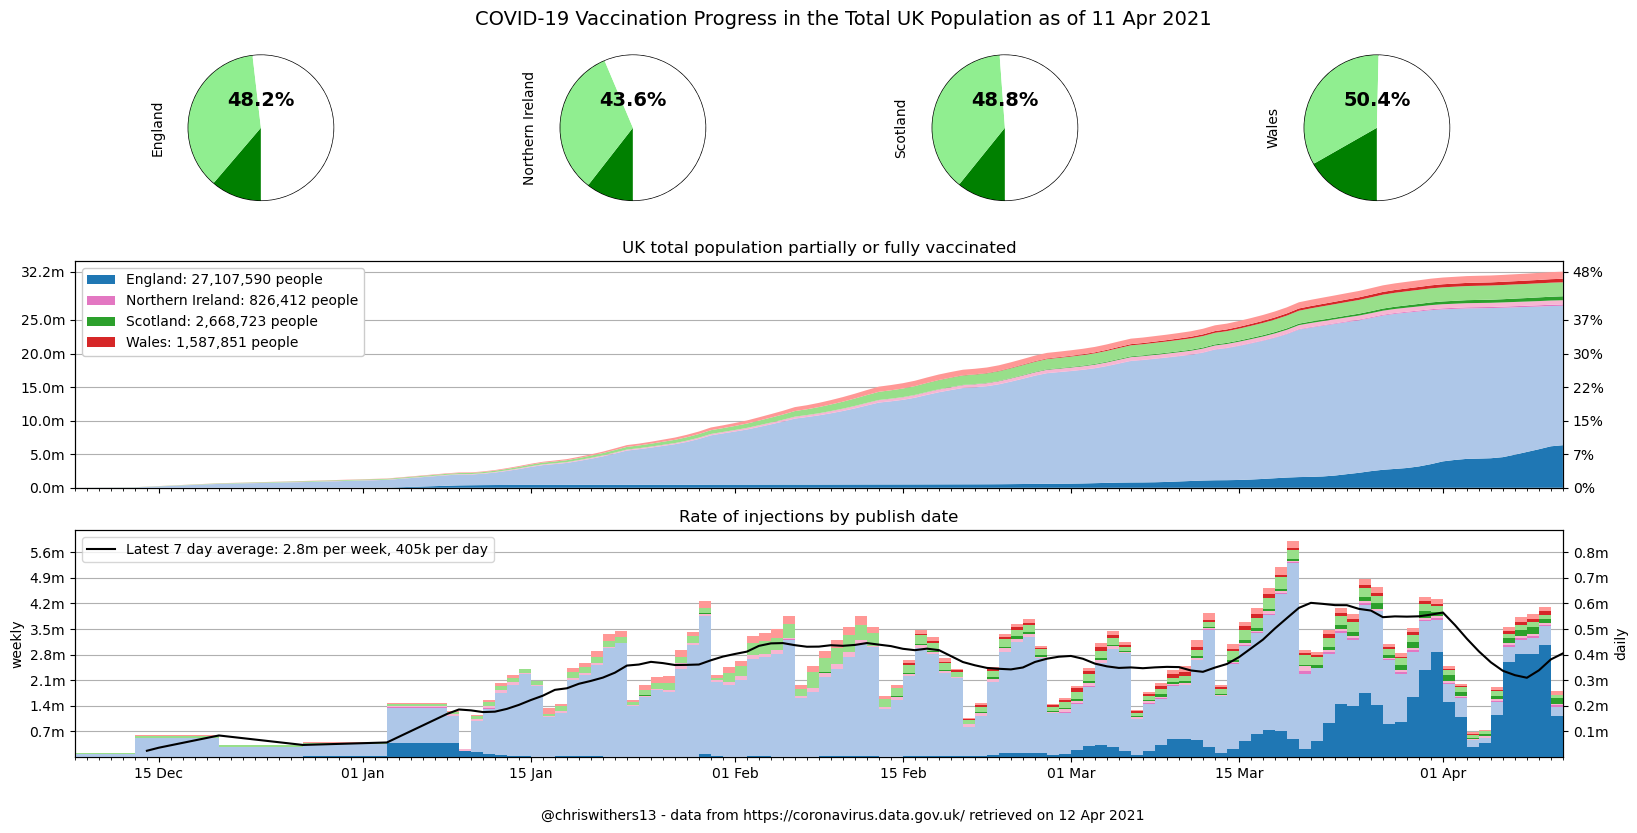

In [7]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

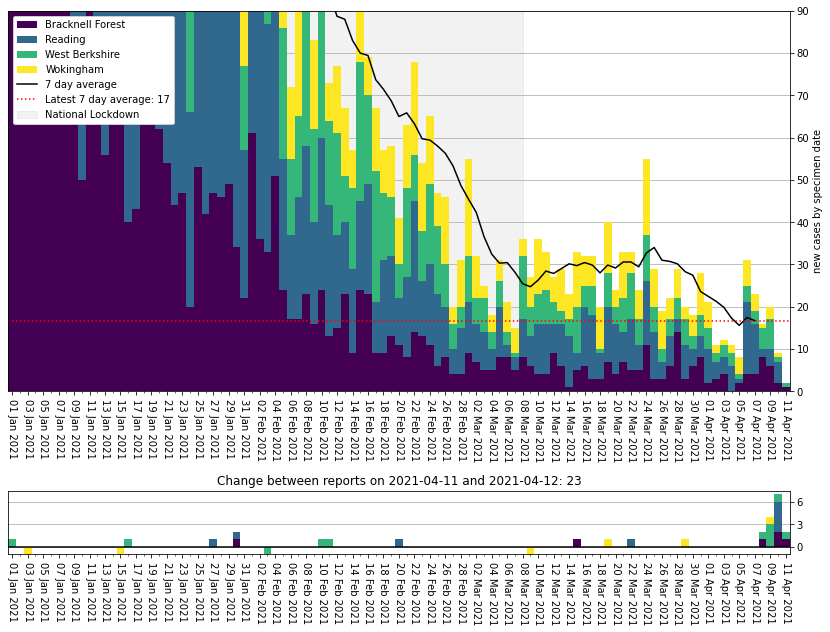

In [8]:
plot_areas(for_date, areas=my_areas, earliest='2021-01-01', ylim=90)

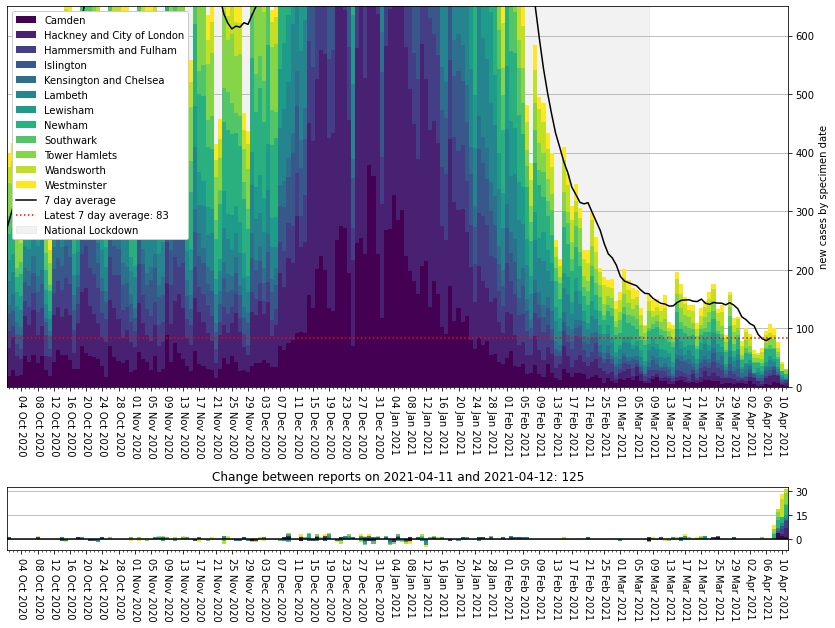

In [9]:
plot_areas(for_date, areas=london_areas, ylim=650)

In [10]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [11]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
N09000005,Derry City and Strabane,85.931096,130.0,2021-04-11
E07000150,Corby,85.851173,62.0,2021-04-11
E07000174,Mansfield,83.247189,91.0,2021-04-11
S12000005,Clackmannanshire,77.609624,40.0,2021-04-11
E08000017,Doncaster,77.591459,242.0,2021-04-11
E08000032,Bradford,76.513220,413.0,2021-04-11
E08000016,Barnsley,76.154675,188.0,2021-04-11
E07000136,Boston,74.102575,52.0,2021-04-11
E06000032,Luton,71.344085,152.0,2021-04-11


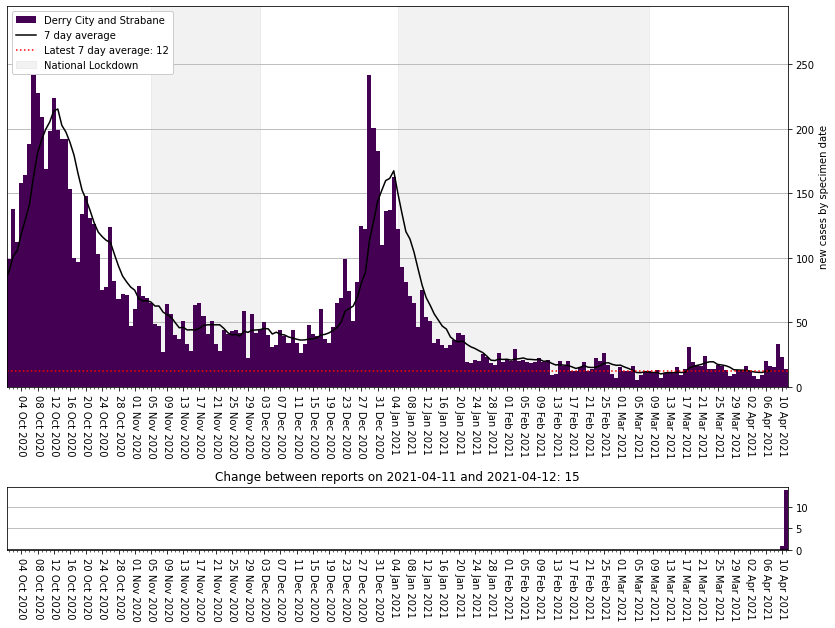

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [13]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000032,Bradford,76.513220,413.0,2021-04-11
E08000035,Leeds,51.315091,407.0,2021-04-11
E08000019,Sheffield,56.424435,330.0,2021-04-11
S12000049,Glasgow City,51.175133,324.0,2021-04-11
E08000034,Kirklees,62.757653,276.0,2021-04-11
E08000025,Birmingham,24.172021,276.0,2021-04-11
E08000003,Manchester,45.038690,249.0,2021-04-11
E08000017,Doncaster,77.591459,242.0,2021-04-11
E08000036,Wakefield,68.329544,238.0,2021-04-11


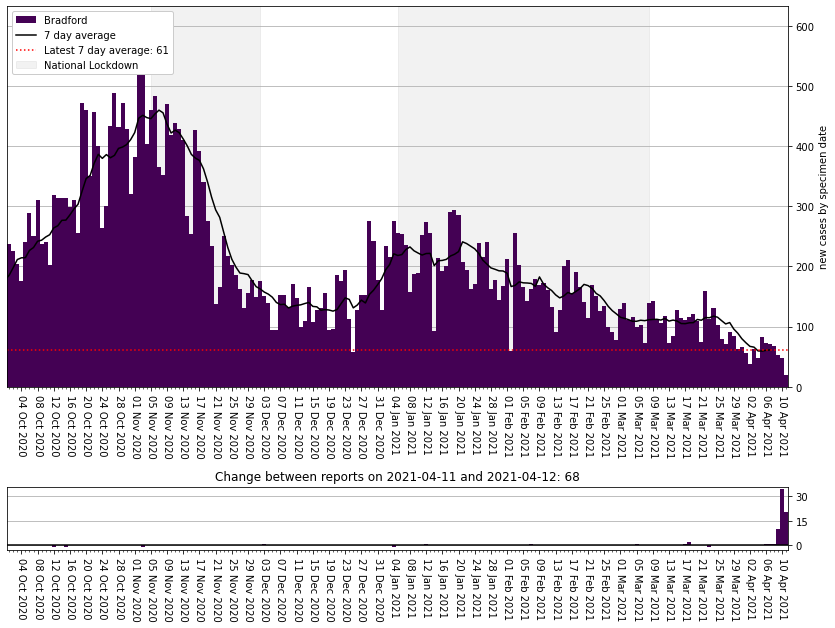

In [14]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [15]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.0
phe_max = 0.13

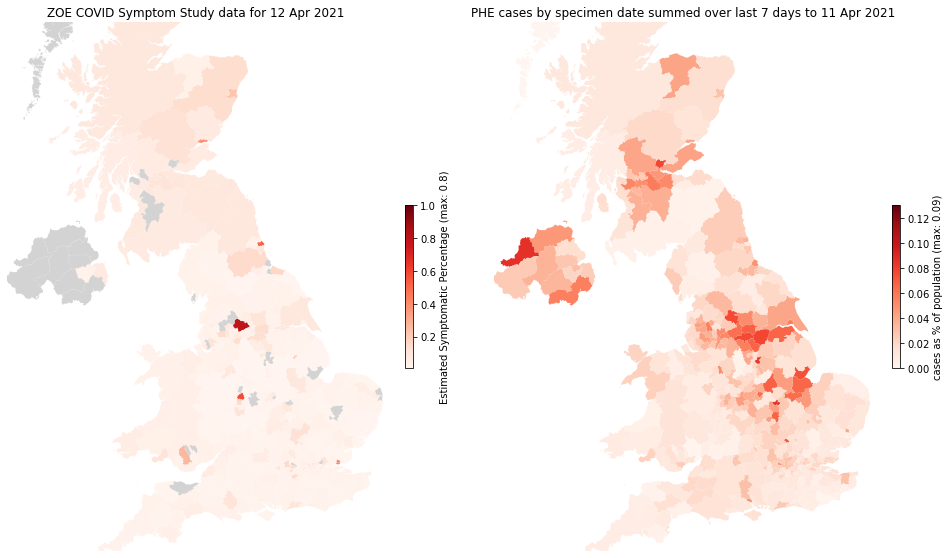

In [16]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [17]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...